In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/MEGAsync/IIT/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
data = pd.read_csv("C:/Users/Phanthom/MEGAsync/IIT/SDGP/Dataset/db.csv")

In [3]:
data.head(1)

,Отметка времени,Имя/Никнейм,Пол,Возраст,Максимальный рейтинг в Доте,Рейтинг в доте на данный момент,Количество часов в игре (хотя бы примерное),Какое количество игр в среднем ты играешь в неделю?,"У меня ухудшается настроение, если я долго не играю в Доту 2",Почти все свое свободное время я трачу на Доту 2,...,У меня есть конкретная цель - апнуть птсы (например: взять 6к mmr или медаль властелина/дивайна/титана),"Я играю в доту для того, чтобы побеждать",В доте слишком многое зависит не от меня и моей игры,"Если я проигрываю, то это чаще всего связано с плохой игрой тиммейтов","Если бы у меня была сильная команда в каждой игре, я бы почти не проигрывал","Мой возможный птс намного больше, чем мой актуальный",Я долгое время сижу на одном и том же рейтинге без видимого прогресса,"У меня часто пропадает желание играть, когда мои тиммейты играют плохо","MMR - это всего лишь цифра, она не показывает реальный скилл игрока","Напиши трех героев, на которых у тебя сыграно больше всего игр, количество и винрейт на этих персонажах (например: Пудж, 152 игры, 56%):"
0,2021/11/07 5:29:50 PM GMT+3,Серегга,М,26,5300,4800,5000,NaN,4,3,...,3,1,3,1,3,4,NaN,4,4,Феникс - 774 (56%)\nPudge - 146 (45%)\nSpirit ...


In [4]:
data_row = data.iloc[:, 3:-1]
data_row['Максимальный рейтинг в Доте'] = data_row['Максимальный рейтинг в Доте'].str.extract('(\d+)', expand=False)
data_row['Рейтинг в доте на данный момент'] = data_row['Рейтинг в доте на данный момент'].str.extract('(\d+)', expand=False)
data_row['Количество часов в игре (хотя бы примерное)'] = data_row['Количество часов в игре (хотя бы примерное)'].str.extract('(\d+)', expand=False)
data_row['Какое количество игр в среднем ты играешь в неделю? '] = data_row['Какое количество игр в среднем ты играешь в неделю? '].str.extract('(\d+)', expand=False)
data_row['Возраст'] = data_row['Возраст'].str.extract('(\d+)', expand=False)
df = data_row.fillna(0)
df = df.replace(to_replace = 0, value = 0)
df = df.dropna()
df = df.astype('float32')
df = df.drop(np.where(df['Рейтинг в доте на данный момент'] > 10000)[0])
df = df.drop(np.where(df['Максимальный рейтинг в Доте'] > 10000)[0])
df = df.loc[df['Рейтинг в доте на данный момент'] > 200]
df = df.loc[df['Максимальный рейтинг в Доте'] > 200]
df = df.loc[df['Количество часов в игре (хотя бы примерное)'] > 200]
df = df.loc[df['Рейтинг в доте на данный момент'] <= df['Максимальный рейтинг в Доте']]
df = df.loc[df['Количество часов в игре (хотя бы примерное)'] < 30000]
df = df.astype('float32')
df = df.drop('Максимальный рейтинг в Доте',axis=1)

In [5]:
df['target'] = df['Рейтинг в доте на данный момент']
df = df.drop(columns=['Рейтинг в доте на данный момент'])

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [8]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

C:\Users\Phanthom\AppData\Local\Temp\ipykernel_175320\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [9]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Возраст'])
print('A batch of targets:', label_batch )

Every feature: ['Возраст', 'Количество часов в игре (хотя бы примерное)', 'Какое количество игр в среднем ты играешь в неделю? ', 'У меня ухудшается настроение, если я долго не играю в Доту 2', 'Почти все свое свободное время я трачу на Доту 2', 'Я часто играю больше, чем нужно, так как не могу остановиться (регаю новую игру)', 'Когда я играю в Доту я полностью над ней сосредоточен (не играю "фо фан")', 'С каждой неделей/месяцем я провожу в Доте все больше времени, чем раньше', 'Я часто регаю некст игру несмотря на дискомфорт (я могу играть голодный, не выспавшийся, в плохом самочувствии и т.д.)', 'Я не рассказываю семье/друзьям о количестве часов, которое я провожу в Доте', 'Дота позволяет мне забыть о стрессе и жизненных проблемах ирл', 'Из-за количества часов, проводимых в игре я хуже учусь/работаю/выполняю иные задачи', 'Каждую игру в доте я играю на победу', 'Я часто играю в доту фо фан - мне интересен сам процесс игры (пробую разные сборки, новых героев, связки и тд)', 'Если мне 

In [10]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

  # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [rating]')
    plt.legend()
    plt.grid(True)

In [11]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

C:\Users\Phanthom\AppData\Local\Temp\ipykernel_175320\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\Phanthom\AppData\Local\Temp\ipykernel_175320\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\Phanthom\AppData\Local\Temp\ipykernel_175320\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [12]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['Возраст', 'Количество часов в игре (хотя бы примерное)']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
categorical_cols = df.columns[2:-1]

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='float')
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='float',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

Epoch 1/500


c:\Users\Phanthom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/20 - 3s - loss: 2153.0271 - val_loss: 2139.5940 - 3s/epoch - 128ms/step
Epoch 2/500
20/20 - 0s - loss: 2132.2351 - val_loss: 2086.6865 - 162ms/epoch - 8ms/step
Epoch 3/500
20/20 - 0s - loss: 1998.4015 - val_loss: 1793.3391 - 162ms/epoch - 8ms/step
Epoch 4/500
20/20 - 0s - loss: 1510.0281 - val_loss: 1173.8557 - 160ms/epoch - 8ms/step
Epoch 5/500
20/20 - 0s - loss: 1126.3685 - val_loss: 1079.0144 - 151ms/epoch - 8ms/step
Epoch 6/500
20/20 - 0s - loss: 1091.7802 - val_loss: 1065.6350 - 167ms/epoch - 8ms/step
Epoch 7/500
20/20 - 0s - loss: 1069.5941 - val_loss: 1037.5389 - 185ms/epoch - 9ms/step
Epoch 8/500
20/20 - 0s - loss: 1046.6521 - val_loss: 1016.9559 - 192ms/epoch - 10ms/step
Epoch 9/500
20/20 - 0s - loss: 1022.0902 - val_loss: 993.4103 - 170ms/epoch - 9ms/step
Epoch 10/500
20/20 - 0s - loss: 994.6593 - val_loss: 967.2932 - 162ms/epoch - 8ms/step
Epoch 11/500
20/20 - 0s - loss: 964.4404 - val_loss: 935.1523 - 146ms/epoch - 7ms/step
Epoch 12/500
20/20 - 0s - loss: 928.8150 - val_

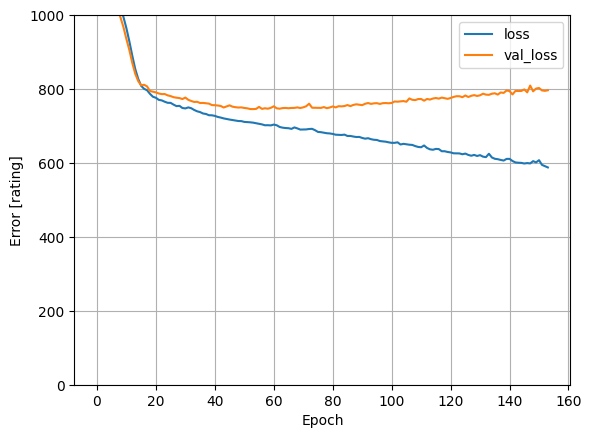

In [18]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer='l2')(all_features)
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer='l2')(x)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer='l2')(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
checkpoint_filepath = 'C:/Users/Phanthom/AppData/Local/Temp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=0.001),
              loss='mean_absolute_error',
              )

history = model.fit(train_ds, epochs=500, verbose=2, validation_data=val_ds, callbacks=[callback, model_checkpoint_callback])
plot_loss(history)
model.load_weights(checkpoint_filepath)

In [1]:
def otvet(df, model):
    X_test = {}
    for i in range(0,len(df.columns[:-1])):
        print(df.columns[i], str(i+1))
        a = float(input())
        X_test[df.columns[i]] = a
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in X_test.items()}
    predictions = model.predict(input_dict)
    return predictions

NameError: name 'df1' is not defined